In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run SharedFunctions.ipynb

In [11]:
data = pd.read_csv('data/just_train.csv')

data.comment_text=data.comment_text.astype(str)

In [12]:
X = data['comment_text']
y = data['target']

In [13]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [14]:
X_train.shape, X_validation.shape, X_test.shape

((85529,), (21383,), (52659,))

In [15]:
y_train.shape, y_validation.shape, y_test.shape

((85529,), (21383,), (52659,))

In [16]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [17]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binaryTrain.pickle')
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 143757


In [18]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [19]:
X_train.shape, X_test.shape, X_validation.shape

((85529, 100), (52659, 100), (21383, 100))

In [20]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

In [21]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.3
embedding_dim = 100
lr = 0.0001

In [22]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, lr = lr, embedding_matrix = embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0

In [23]:
weights = get_weights(y_train)

# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija
weights

{0: 0.5565975114535611, 1: 4.917155340922157}

In [24]:
weights[1] = 3.99

In [25]:
epochs = 10
batch_size = 64

In [26]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
1337/1337 [==============================] - 17s 13ms/step - loss: 0.4695 - accuracy: 0.8161 - val_loss: 0.3344 - val_accuracy: 0.8839
Epoch 2/10
1337/1337 [==============================] - 16s 12ms/step - loss: 0.3363 - accuracy: 0.8727 - val_loss: 0.3054 - val_accuracy: 0.8932
Epoch 3/10
1337/1337 [==============================] - 19s 14ms/step - loss: 0.3039 - accuracy: 0.8932 - val_loss: 0.3572 - val_accuracy: 0.8713
Epoch 4/10
1337/1337 [==============================] - 21s 16ms/step - loss: 0.2825 - accuracy: 0.9040 - val_loss: 0.2738 - val_accuracy: 0.9088
Epoch 5/10
1337/1337 [==============================] - 23s 17ms/step - loss: 0.2685 - accuracy: 0.9100 - val_loss: 0.2384 - val_accuracy: 0.9219
Epoch 6/10
1337/1337 [==============================] - 25s 18ms/step - loss: 0.2593 - accuracy: 0.9134 - val_loss: 0.2470 - val_accuracy: 0.9171
Epoch 7/10
1337/1337 [==============================] - 25s 19ms/step - loss: 0.2491 - accuracy: 0.9169 - val_loss: 0.2157 -

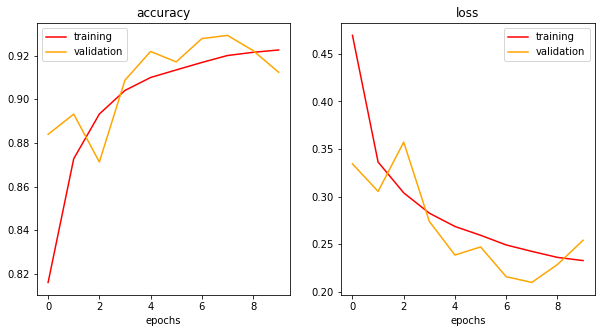

In [27]:
plot_graphs(binary_history, ['accuracy', 'loss'])

In [28]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])

1646/1646 [==============================] - 4s 3ms/step - loss: 0.2502 - accuracy: 0.9162
Loss:  0.2502013146877289
Test accuracy:  0.9162156581878662


In [29]:
y_predicted = binary_model.predict(X_test)

In [30]:
y_labels = [int(score > 0.5) for score in y_predicted]

In [31]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6776267718836767


In [32]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[43610  3695]
 [  717  4637]]


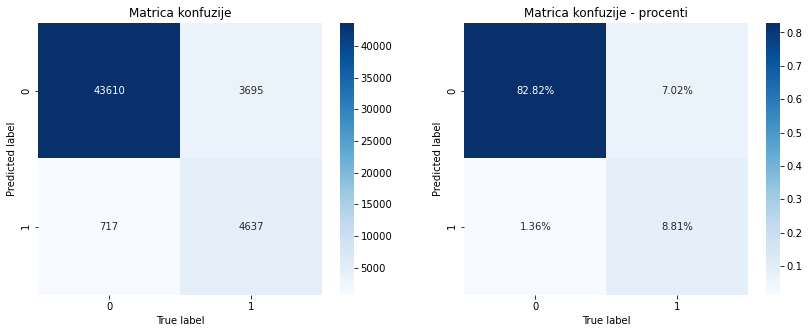

In [33]:
plot_cf(cf)

In [ ]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))